# Análisis de Duración Promedio del Matrimonio en Guatemala
## Ciclos de Vida Matrimonial y Patrones de Estabilidad (2011-2021)

---

### 🔬 Objetivo del Análisis

**"Determinar la duración promedio del matrimonio antes del divorcio en Guatemala, identificar patrones por género, departamento y período temporal, y clasificar matrimonios según su estabilidad"**

---

### 📋 Preguntas de Investigación

1. ¿Cuál es la duración promedio del matrimonio antes del divorcio?
2. ¿Existen diferencias significativas por género?
3. ¿Qué departamentos tienen matrimonios más duraderos?
4. ¿Ha cambiado la duración promedio en la última década?
5. ¿Se pueden identificar clusters de estabilidad matrimonial?

---

### 💡 Metodología

**Cálculo de duración:**
```
Duración = Edad al Divorcio - Edad Promedio al Matrimonio (por depto/año)
```

**Nota metodológica:** Usamos estimaciones basadas en las edades promedio al matrimonio por departamento y año.

---

## 1. Configuración Inicial y Carga de Librerías

In [1]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.patches as mpatches

# Librerías para análisis estadístico
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, pearsonr, f_oneway, kruskal

# Librerías para clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Configuración
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✓ Librerías cargadas correctamente")

✓ Librerías cargadas correctamente


## 2. Carga y Preparación de Datos

In [2]:
# Cargar datasets
divorcios = pd.read_csv('div_full.csv', encoding='utf-8')
matrimonios = pd.read_csv('mat_full.csv', encoding='utf-8')

print(f"✓ Divorcios cargados: {divorcios.shape[0]:,} registros")
print(f"✓ Matrimonios cargados: {matrimonios.shape[0]:,} registros")

✓ Divorcios cargados: 56,349 registros
✓ Matrimonios cargados: 752,264 registros


### 2.1 Limpieza de Datos

In [3]:
# Mapeo de departamentos (normalización de nombres)
mapeo_departamentos = {
    'Suchitepequez': 'Suchitepéquez',
    'Peten': 'Petén',
    'Quiche': 'Quiché',
    'Sacatepequez': 'Sacatepéquez',
    'Totonicapan': 'Totonicapán',
    'Solola': 'Sololá'
}

# Aplicar mapeo
divorcios['DEPREG'] = divorcios['DEPREG'].replace(mapeo_departamentos)
matrimonios['DEPREG'] = matrimonios['DEPREG'].replace(mapeo_departamentos)

# Convertir columnas numéricas
for col in ['AÑOREG', 'EDADHOM', 'EDADMUJ']:
    divorcios[col] = pd.to_numeric(divorcios[col], errors='coerce')
    matrimonios[col] = pd.to_numeric(matrimonios[col], errors='coerce')

print("✓ Datos preparados")

✓ Datos preparados


## 3. Cálculo de Edad Promedio al Matrimonio

Calculamos la edad promedio al matrimonio por departamento y año como referencia.

In [4]:
# Filtrar datos válidos de matrimonios
matrimonios_clean = matrimonios[
    (matrimonios['EDADHOM'].notna()) & 
    (matrimonios['EDADMUJ'].notna()) &
    (matrimonios['EDADHOM'].between(15, 100)) &
    (matrimonios['EDADMUJ'].between(14, 100))
].copy()

# Calcular edad promedio al matrimonio por departamento y año
edad_mat_depto_año = matrimonios_clean.groupby(['DEPREG', 'AÑOREG']).agg({
    'EDADHOM': 'mean',
    'EDADMUJ': 'mean'
}).reset_index()

edad_mat_depto_año.rename(columns={
    'EDADHOM': 'Edad_Mat_Hombre',
    'EDADMUJ': 'Edad_Mat_Mujer'
}, inplace=True)

# También calcular promedios nacionales como fallback
edad_mat_nacional = matrimonios_clean.groupby('AÑOREG').agg({
    'EDADHOM': 'mean',
    'EDADMUJ': 'mean'
}).reset_index()

edad_mat_nacional.rename(columns={
    'EDADHOM': 'Edad_Mat_Hombre_Nacional',
    'EDADMUJ': 'Edad_Mat_Mujer_Nacional'
}, inplace=True)

print("✓ Edad promedio al matrimonio calculada")
print(f"\nEdades promedio al matrimonio (nacional, todo el período):")
print(f"  Hombres: {matrimonios_clean['EDADHOM'].mean():.2f} años")
print(f"  Mujeres: {matrimonios_clean['EDADMUJ'].mean():.2f} años")

✓ Edad promedio al matrimonio calculada

Edades promedio al matrimonio (nacional, todo el período):
  Hombres: 29.37 años
  Mujeres: 26.37 años


## 4. Cálculo de Duración del Matrimonio

Estimamos la duración usando: Edad al Divorcio - Edad al Matrimonio

In [5]:
# Filtrar divorcios con edades válidas
divorcios_clean = divorcios[
    (divorcios['EDADHOM'].notna()) & 
    (divorcios['EDADMUJ'].notna()) &
    (divorcios['EDADHOM'].between(15, 100)) &
    (divorcios['EDADMUJ'].between(14, 100))
].copy()

print(f"Divorcios con datos válidos: {len(divorcios_clean):,}")

# Hacer merge con edad promedio al matrimonio
divorcios_clean = divorcios_clean.merge(
    edad_mat_depto_año,
    on=['DEPREG', 'AÑOREG'],
    how='left'
)

# Merge con promedios nacionales para casos sin match
divorcios_clean = divorcios_clean.merge(
    edad_mat_nacional,
    on='AÑOREG',
    how='left'
)

# Usar departamental si existe, sino nacional
divorcios_clean['Edad_Mat_Hombre_Final'] = divorcios_clean['Edad_Mat_Hombre'].fillna(
    divorcios_clean['Edad_Mat_Hombre_Nacional']
)
divorcios_clean['Edad_Mat_Mujer_Final'] = divorcios_clean['Edad_Mat_Mujer'].fillna(
    divorcios_clean['Edad_Mat_Mujer_Nacional']
)

# Calcular duración
divorcios_clean['Duracion_Hombre'] = divorcios_clean['EDADHOM'] - divorcios_clean['Edad_Mat_Hombre_Final']
divorcios_clean['Duracion_Mujer'] = divorcios_clean['EDADMUJ'] - divorcios_clean['Edad_Mat_Mujer_Final']
divorcios_clean['Duracion_Promedio'] = (divorcios_clean['Duracion_Hombre'] + divorcios_clean['Duracion_Mujer']) / 2

# Filtrar duraciones razonables (0-60 años)
divorcios_duracion = divorcios_clean[
    (divorcios_clean['Duracion_Promedio'] >= 0) &
    (divorcios_clean['Duracion_Promedio'] <= 60)
].copy()

print(f"\n✓ Duración calculada para {len(divorcios_duracion):,} divorcios")
print(f"\nEstadísticas de duración:")
print(f"  Media: {divorcios_duracion['Duracion_Promedio'].mean():.2f} años")
print(f"  Mediana: {divorcios_duracion['Duracion_Promedio'].median():.2f} años")
print(f"  Desv. Est.: {divorcios_duracion['Duracion_Promedio'].std():.2f} años")
print(f"  Mínimo: {divorcios_duracion['Duracion_Promedio'].min():.2f} años")
print(f"  Máximo: {divorcios_duracion['Duracion_Promedio'].max():.2f} años")

Divorcios con datos válidos: 23,297

✓ Duración calculada para 15,014 divorcios

Estadísticas de duración:
  Media: 9.06 años
  Mediana: 6.63 años
  Desv. Est.: 8.14 años
  Mínimo: 0.00 años
  Máximo: 54.07 años


## 5. Análisis Descriptivo General

### 5.1 Distribución de Duración

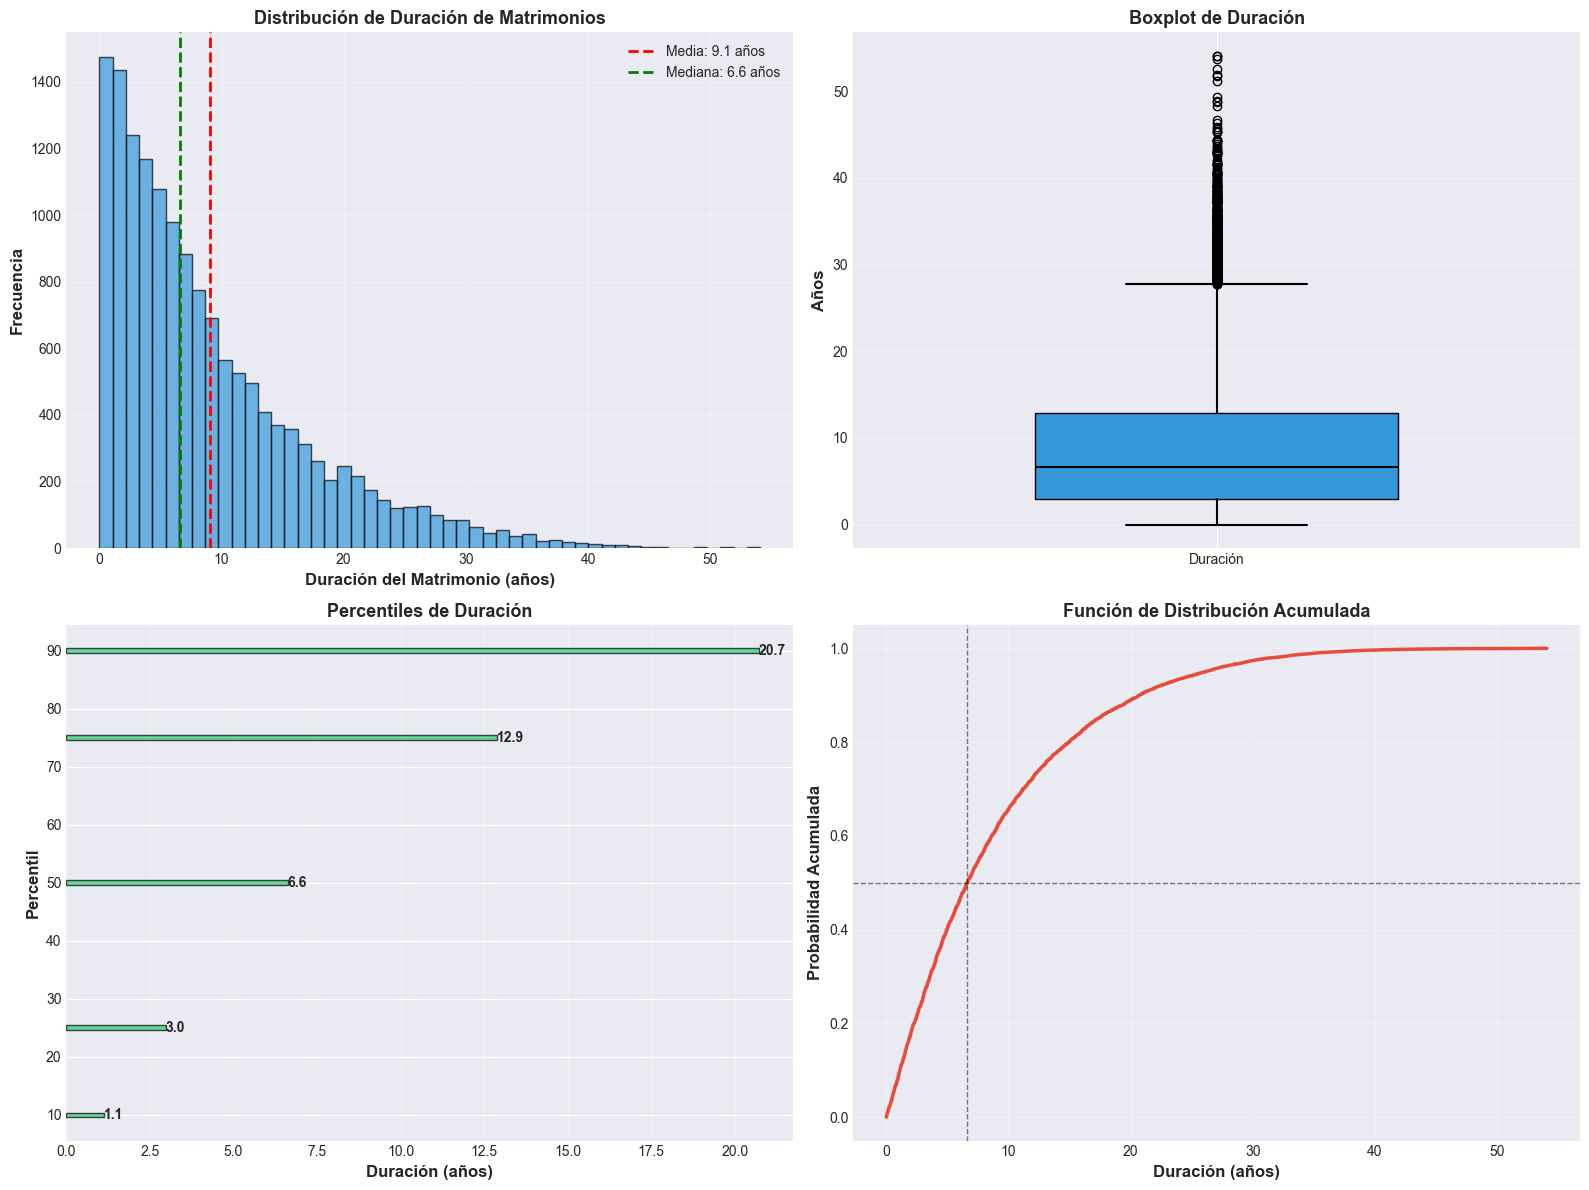

✓ Gráficos de distribución generados


In [6]:
# Visualización de distribución
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 5.1.1 Histograma
ax1 = axes[0, 0]
ax1.hist(divorcios_duracion['Duracion_Promedio'], bins=50, color='#3498DB', 
         alpha=0.7, edgecolor='black')
ax1.axvline(divorcios_duracion['Duracion_Promedio'].mean(), color='red', 
           linestyle='--', linewidth=2, label=f'Media: {divorcios_duracion["Duracion_Promedio"].mean():.1f} años')
ax1.axvline(divorcios_duracion['Duracion_Promedio'].median(), color='green', 
           linestyle='--', linewidth=2, label=f'Mediana: {divorcios_duracion["Duracion_Promedio"].median():.1f} años')
ax1.set_xlabel('Duración del Matrimonio (años)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
ax1.set_title('Distribución de Duración de Matrimonios', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# 5.1.2 Boxplot
ax2 = axes[0, 1]
bp = ax2.boxplot([divorcios_duracion['Duracion_Promedio']], 
                  labels=['Duración'],
                  patch_artist=True, widths=0.5)
bp['boxes'][0].set_facecolor('#3498DB')
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color='black', linewidth=1.5)
ax2.set_ylabel('Años', fontsize=12, fontweight='bold')
ax2.set_title('Boxplot de Duración', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# 5.1.3 Percentiles
ax3 = axes[1, 0]
percentiles = [10, 25, 50, 75, 90]
valores_percentiles = [divorcios_duracion['Duracion_Promedio'].quantile(p/100) for p in percentiles]
bars = ax3.barh(percentiles, valores_percentiles, color='#2ECC71', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Duración (años)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Percentil', fontsize=12, fontweight='bold')
ax3.set_title('Percentiles de Duración', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')
# Añadir valores
for i, (bar, val) in enumerate(zip(bars, valores_percentiles)):
    ax3.text(val, bar.get_y() + bar.get_height()/2, f'{val:.1f}',
            ha='left', va='center', fontsize=10, fontweight='bold')

# 5.1.4 Distribución acumulada
ax4 = axes[1, 1]
sorted_dur = np.sort(divorcios_duracion['Duracion_Promedio'])
cdf = np.arange(1, len(sorted_dur) + 1) / len(sorted_dur)
ax4.plot(sorted_dur, cdf, linewidth=2.5, color='#E74C3C')
ax4.axhline(0.5, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax4.axvline(divorcios_duracion['Duracion_Promedio'].median(), color='black', 
           linestyle='--', linewidth=1, alpha=0.5)
ax4.set_xlabel('Duración (años)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Probabilidad Acumulada', fontsize=12, fontweight='bold')
ax4.set_title('Función de Distribución Acumulada', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Gráficos de distribución generados")

### 5.2 Estadísticas por Percentiles

In [7]:
print("ANÁLISIS POR PERCENTILES")
print("="*80)
percentiles = [10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    val = divorcios_duracion['Duracion_Promedio'].quantile(p/100)
    print(f"  P{p:02d}: {val:.2f} años - {p}% de los matrimonios duran menos de {val:.1f} años")

print("\nINTERPRETACIÓN:")
p50 = divorcios_duracion['Duracion_Promedio'].quantile(0.50)
p25 = divorcios_duracion['Duracion_Promedio'].quantile(0.25)
p75 = divorcios_duracion['Duracion_Promedio'].quantile(0.75)
print(f"  • La mitad de los matrimonios terminan en menos de {p50:.1f} años")
print(f"  • El 25% más corto dura menos de {p25:.1f} años")
print(f"  • El 25% más largo dura más de {p75:.1f} años")

ANÁLISIS POR PERCENTILES
  P10: 1.11 años - 10% de los matrimonios duran menos de 1.1 años
  P25: 2.98 años - 25% de los matrimonios duran menos de 3.0 años
  P50: 6.63 años - 50% de los matrimonios duran menos de 6.6 años
  P75: 12.88 años - 75% de los matrimonios duran menos de 12.9 años
  P90: 20.71 años - 90% de los matrimonios duran menos de 20.7 años
  P95: 26.10 años - 95% de los matrimonios duran menos de 26.1 años
  P99: 35.18 años - 99% de los matrimonios duran menos de 35.2 años

INTERPRETACIÓN:
  • La mitad de los matrimonios terminan en menos de 6.6 años
  • El 25% más corto dura menos de 3.0 años
  • El 25% más largo dura más de 12.9 años


## 6. Análisis por Género

Comparamos la duración desde la perspectiva de hombres y mujeres.

In [8]:
print("DURACIÓN POR GÉNERO")
print(f"\nHOMBRES:")
print(f"  Media: {divorcios_duracion['Duracion_Hombre'].mean():.2f} años")
print(f"  Mediana: {divorcios_duracion['Duracion_Hombre'].median():.2f} años")
print(f"  Desv. Est.: {divorcios_duracion['Duracion_Hombre'].std():.2f} años")

print(f"\nMUJERES:")
print(f"  Media: {divorcios_duracion['Duracion_Mujer'].mean():.2f} años")
print(f"  Mediana: {divorcios_duracion['Duracion_Mujer'].median():.2f} años")
print(f"  Desv. Est.: {divorcios_duracion['Duracion_Mujer'].std():.2f} años")

# Test estadístico
stat_t, p_t = ttest_ind(divorcios_duracion['Duracion_Hombre'], 
                        divorcios_duracion['Duracion_Mujer'])
stat_mw, p_mw = mannwhitneyu(divorcios_duracion['Duracion_Hombre'], 
                             divorcios_duracion['Duracion_Mujer'])

print(f"\n🔬 TESTS ESTADÍSTICOS:")
print(f"  Test t: t={stat_t:.4f}, p={p_t:.6f}")
print(f"  Mann-Whitney U: U={stat_mw:.2f}, p={p_mw:.6f}")

if p_t < 0.05:
    diff = divorcios_duracion['Duracion_Hombre'].mean() - divorcios_duracion['Duracion_Mujer'].mean()
    print(f"\n Diferencia SIGNIFICATIVA: {abs(diff):.2f} años")
else:
    print(f"\nNo hay diferencia significativa entre géneros")

DURACIÓN POR GÉNERO

HOMBRES:
  Media: 9.43 años
  Mediana: 6.94 años
  Desv. Est.: 9.29 años

MUJERES:
  Media: 8.69 años
  Mediana: 6.66 años
  Desv. Est.: 8.38 años

🔬 TESTS ESTADÍSTICOS:
  Test t: t=7.2813, p=0.000000
  Mann-Whitney U: U=115787876.00, p=0.000042

 Diferencia SIGNIFICATIVA: 0.74 años


### 6.1 Visualización por Género

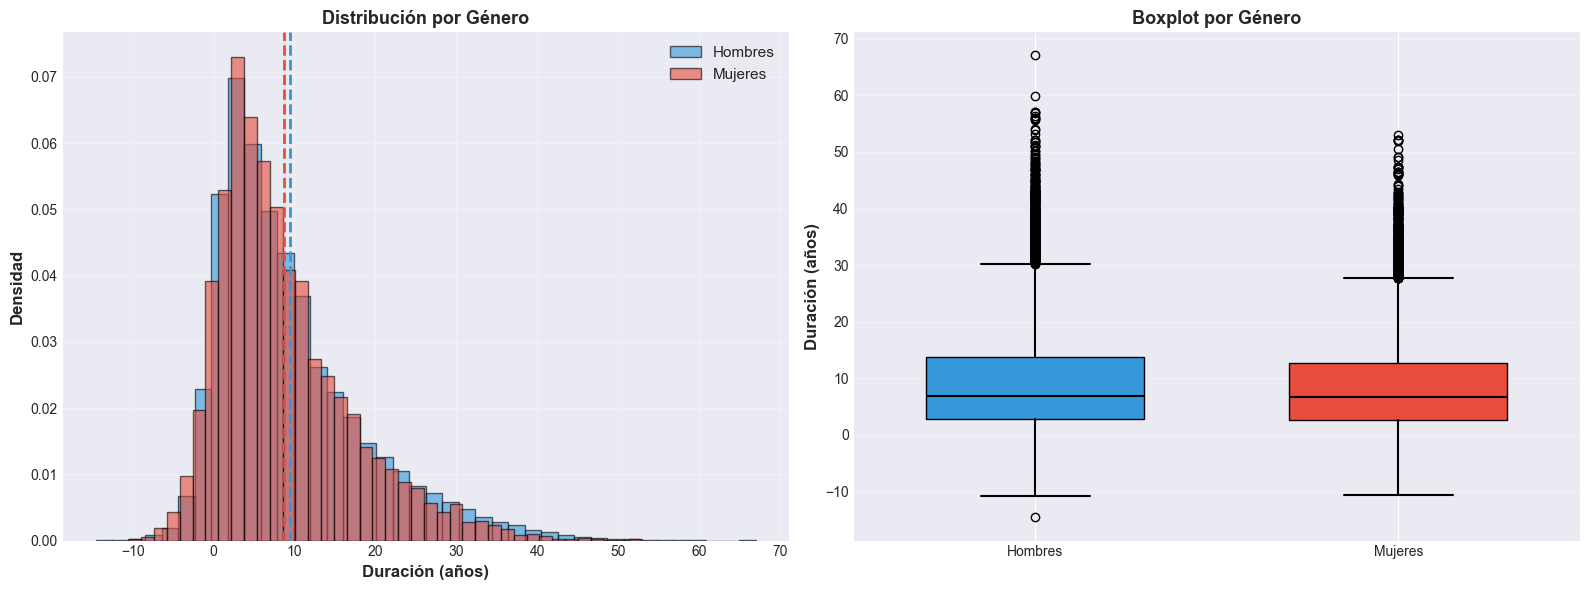

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 6.1.1 Histogramas comparativos
ax1 = axes[0]
ax1.hist(divorcios_duracion['Duracion_Hombre'], bins=40, alpha=0.6, 
         color='#3498DB', label='Hombres', edgecolor='black', density=True)
ax1.hist(divorcios_duracion['Duracion_Mujer'], bins=40, alpha=0.6, 
         color='#E74C3C', label='Mujeres', edgecolor='black', density=True)
ax1.axvline(divorcios_duracion['Duracion_Hombre'].mean(), color='#3498DB', 
           linestyle='--', linewidth=2)
ax1.axvline(divorcios_duracion['Duracion_Mujer'].mean(), color='#E74C3C', 
           linestyle='--', linewidth=2)
ax1.set_xlabel('Duración (años)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Densidad', fontsize=12, fontweight='bold')
ax1.set_title('Distribución por Género', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# 6.1.2 Boxplots comparativos
ax2 = axes[1]
bp = ax2.boxplot([divorcios_duracion['Duracion_Hombre'], 
                   divorcios_duracion['Duracion_Mujer']], 
                  labels=['Hombres', 'Mujeres'],
                  patch_artist=True, widths=0.6)
bp['boxes'][0].set_facecolor('#3498DB')
bp['boxes'][1].set_facecolor('#E74C3C')
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color='black', linewidth=1.5)
ax2.set_ylabel('Duración (años)', fontsize=12, fontweight='bold')
ax2.set_title('Boxplot por Género', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 7. Análisis por Departamento

Identificamos diferencias geográficas en la duración del matrimonio.

In [10]:
# Calcular estadísticas por departamento
duracion_por_depto = divorcios_duracion.groupby('DEPREG').agg({
    'Duracion_Promedio': ['mean', 'median', 'std', 'count']
}).reset_index()

duracion_por_depto.columns = ['Departamento', 'Media', 'Mediana', 'Std', 'N']
duracion_por_depto = duracion_por_depto.sort_values('Media', ascending=False)

print("DURACIÓN PROMEDIO POR DEPARTAMENTO")
print("="*80)
print(duracion_por_depto[['Departamento', 'Media', 'Mediana', 'N']].to_string(index=False))

print(f"\nTOP 5 DEPARTAMENTOS CON MAYOR DURACIÓN:")
for i, row in duracion_por_depto.head(5).iterrows():
    print(f"  {i+1}. {row['Departamento']}: {row['Media']:.2f} años ({row['N']:.0f} casos)")

print(f"\nTOP 5 DEPARTAMENTOS CON MENOR DURACIÓN:")
for i, row in duracion_por_depto.tail(5).iterrows():
    print(f"  {i+1}. {row['Departamento']}: {row['Media']:.2f} años ({row['N']:.0f} casos)")

DURACIÓN PROMEDIO POR DEPARTAMENTO
  Departamento    Media  Mediana    N
Quetzaltenango 9.882236 7.402363 1502
 Huehuetenango 9.824510 7.395929  496
  Alta Verapaz 9.780245 7.519717  591
 Chimaltenango 9.730349 7.480188  459
       Jutiapa 9.635149 6.909245  602
  Baja Verapaz 9.562884 6.769907  323
    San Marcos 9.479981 7.096721  588
  Sacatepéquez 9.455934 7.143910  366
 Suchitepéquez 9.441435 6.480780  453
        Jalapa 9.283991 6.351085  304
    Santa Rosa 9.270689 6.742061  363
     Escuintla 9.123874 6.549613  511
    Chiquimula 9.114610 6.646475  372
        Izabal 9.047071 7.243057  412
        Zacapa 8.730013 6.171875  317
     Guatemala 8.682134 6.476691 5491
        Quiché 8.554352 5.846460  413
         Petén 8.492584 5.910752  361
        Sololá 8.378915 5.822318  211
    Retalhuleu 8.159101 5.996172  401
   El Progreso 7.958656 6.148188  216
   Totonicapán 7.888815 4.827988  262

TOP 5 DEPARTAMENTOS CON MAYOR DURACIÓN:
  13. Quetzaltenango: 9.88 años (1502 casos)
  8. 

### 7.1 Test ANOVA - Diferencias entre Departamentos

In [11]:
# Preparar datos para ANOVA
grupos_depto = [group['Duracion_Promedio'].values 
                for name, group in divorcios_duracion.groupby('DEPREG')]

# ANOVA
f_stat, p_anova = f_oneway(*grupos_depto)

# Kruskal-Wallis (no paramétrico)
h_stat, p_kruskal = kruskal(*grupos_depto)

print("\nTESTS DE DIFERENCIAS ENTRE DEPARTAMENTOS")
print("="*80)
print(f"ANOVA: F={f_stat:.4f}, p={p_anova:.10f}")
print(f"Kruskal-Wallis: H={h_stat:.4f}, p={p_kruskal:.10f}")

if p_anova < 0.05:
    print("\nExisten DIFERENCIAS SIGNIFICATIVAS entre departamentos")
else:
    print("\nNo hay diferencias significativas entre departamentos")


TESTS DE DIFERENCIAS ENTRE DEPARTAMENTOS
ANOVA: F=3.2057, p=0.0000009767
Kruskal-Wallis: H=65.9721, p=0.0000015310

Existen DIFERENCIAS SIGNIFICATIVAS entre departamentos


### 7.2 Visualización por Departamento

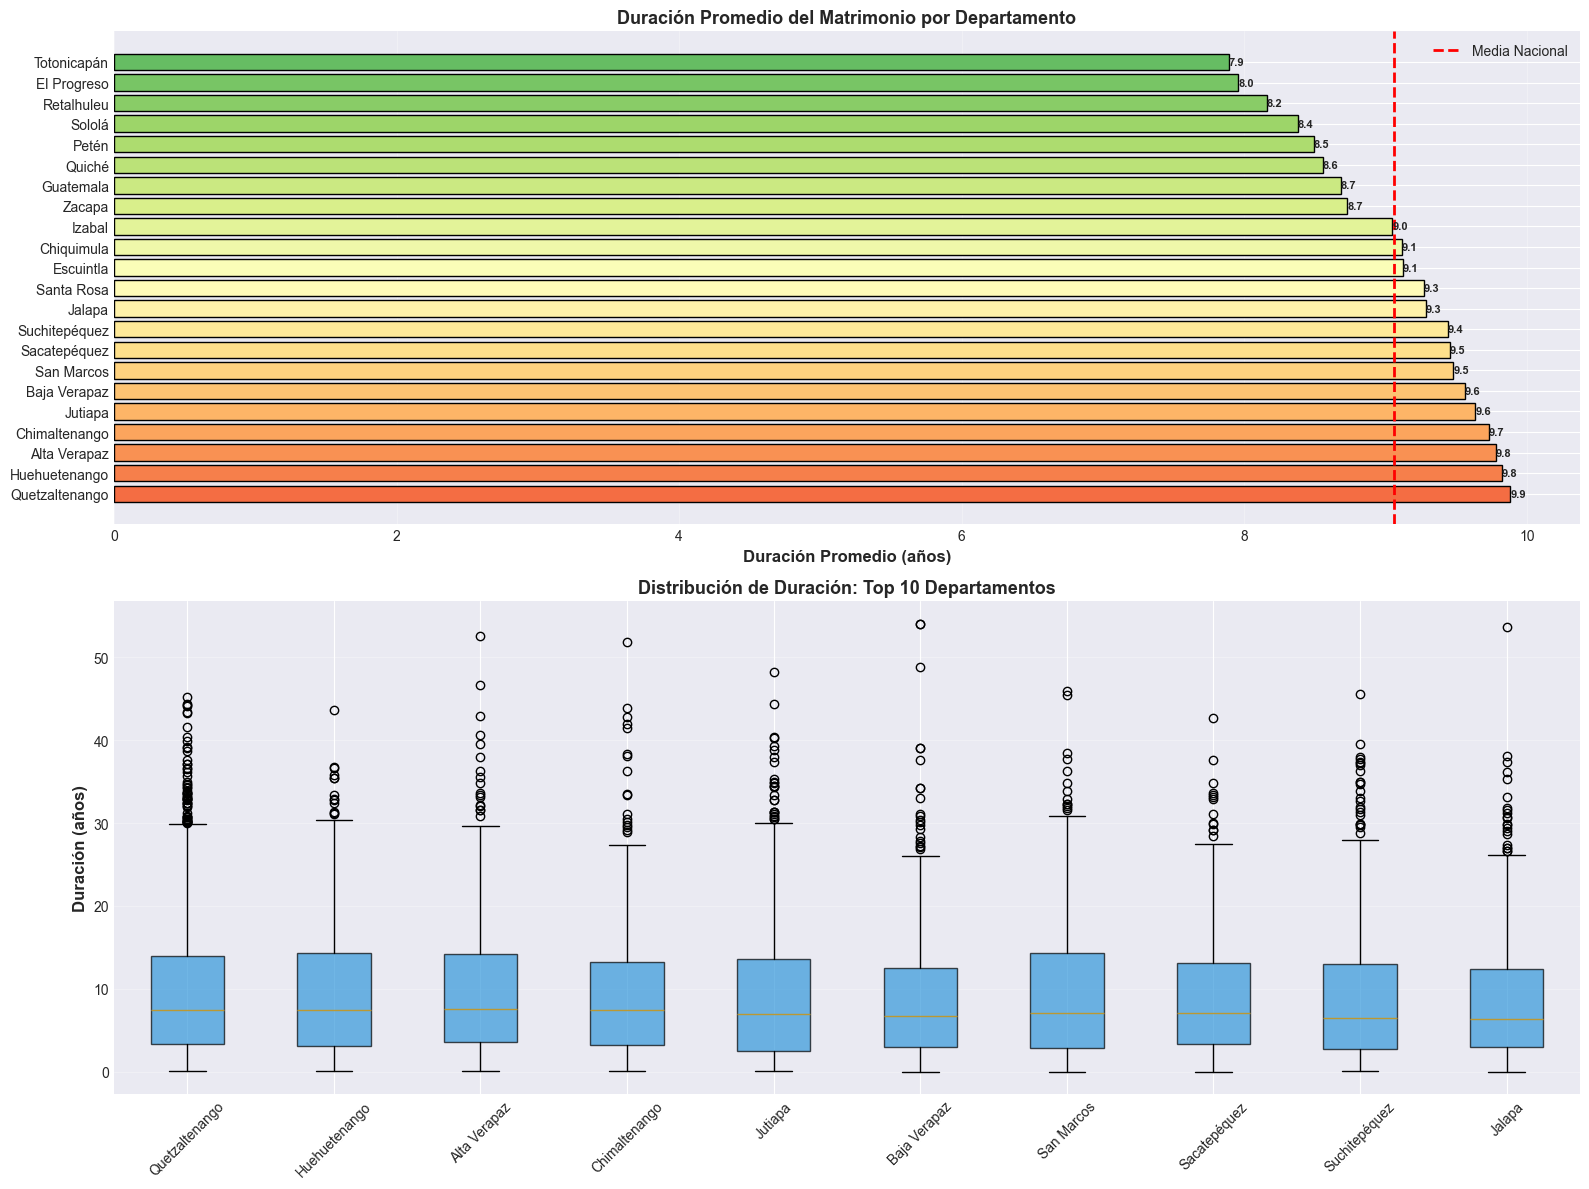

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# 7.2.1 Barras horizontales
ax1 = axes[0]
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(duracion_por_depto)))
bars = ax1.barh(duracion_por_depto['Departamento'], duracion_por_depto['Media'], 
               color=colors, edgecolor='black', linewidth=1)
ax1.axvline(divorcios_duracion['Duracion_Promedio'].mean(), color='red', 
           linestyle='--', linewidth=2, label='Media Nacional')
ax1.set_xlabel('Duración Promedio (años)', fontsize=12, fontweight='bold')
ax1.set_title('Duración Promedio del Matrimonio por Departamento', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3, axis='x')

# Añadir valores
for i, (bar, val) in enumerate(zip(bars, duracion_por_depto['Media'])):
    ax1.text(val, bar.get_y() + bar.get_height()/2, f'{val:.1f}',
            ha='left', va='center', fontsize=8, fontweight='bold')

# 7.2.2 Boxplot por departamento (top 10)
ax2 = axes[1]
top10_deptos = duracion_por_depto.head(10)['Departamento'].tolist()
data_boxplot = [divorcios_duracion[divorcios_duracion['DEPREG'] == depto]['Duracion_Promedio'].values 
                for depto in top10_deptos]
bp = ax2.boxplot(data_boxplot, labels=top10_deptos, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('#3498DB')
    patch.set_alpha(0.7)
ax2.set_ylabel('Duración (años)', fontsize=12, fontweight='bold')
ax2.set_title('Distribución de Duración: Top 10 Departamentos', fontsize=13, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 8. Análisis Temporal

Exploramos cómo ha cambiado la duración del matrimonio a lo largo de los años.

In [13]:
# Calcular por año
duracion_por_año = divorcios_duracion.groupby('AÑOREG').agg({
    'Duracion_Promedio': ['mean', 'median', 'std', 'count']
}).reset_index()

duracion_por_año.columns = ['Año', 'Media', 'Mediana', 'Std', 'N']

print("DURACIÓN PROMEDIO POR AÑO")
print("="*80)
print(duracion_por_año.to_string(index=False))

# Calcular cambio
if len(duracion_por_año) > 1:
    primer_año = duracion_por_año.iloc[0]
    ultimo_año = duracion_por_año.iloc[-1]
    cambio = ultimo_año['Media'] - primer_año['Media']
    cambio_pct = (cambio / primer_año['Media']) * 100
    
    print(f"\nCAMBIO TEMPORAL:")
    print(f"  {int(primer_año['Año'])}: {primer_año['Media']:.2f} años")
    print(f"  {int(ultimo_año['Año'])}: {ultimo_año['Media']:.2f} años")
    print(f"  Cambio: {cambio:+.2f} años ({cambio_pct:+.2f}%)")

DURACIÓN PROMEDIO POR AÑO
   Año     Media  Mediana      Std    N
2011.0 10.070219 7.111556 8.989601  560
2012.0 10.061566 7.835751 8.626051  856
2013.0  9.732547 7.351245 8.614363 1070
2014.0  9.575765 7.077351 8.214941 1255
2015.0  9.125563 6.770630 8.216202 1408
2016.0  8.984342 6.414886 7.972535 1426
2017.0  8.977641 6.395929 8.309212 1567
2018.0  8.951655 6.344882 8.124180 1828
2019.0  8.596874 6.371709 7.753287 2889
2020.0  8.539473 6.146475 7.757859 1669
2021.0  8.503766 6.237421 7.860792  486

CAMBIO TEMPORAL:
  2011: 10.07 años
  2021: 8.50 años
  Cambio: -1.57 años (-15.56%)


### 8.1 Visualización Temporal

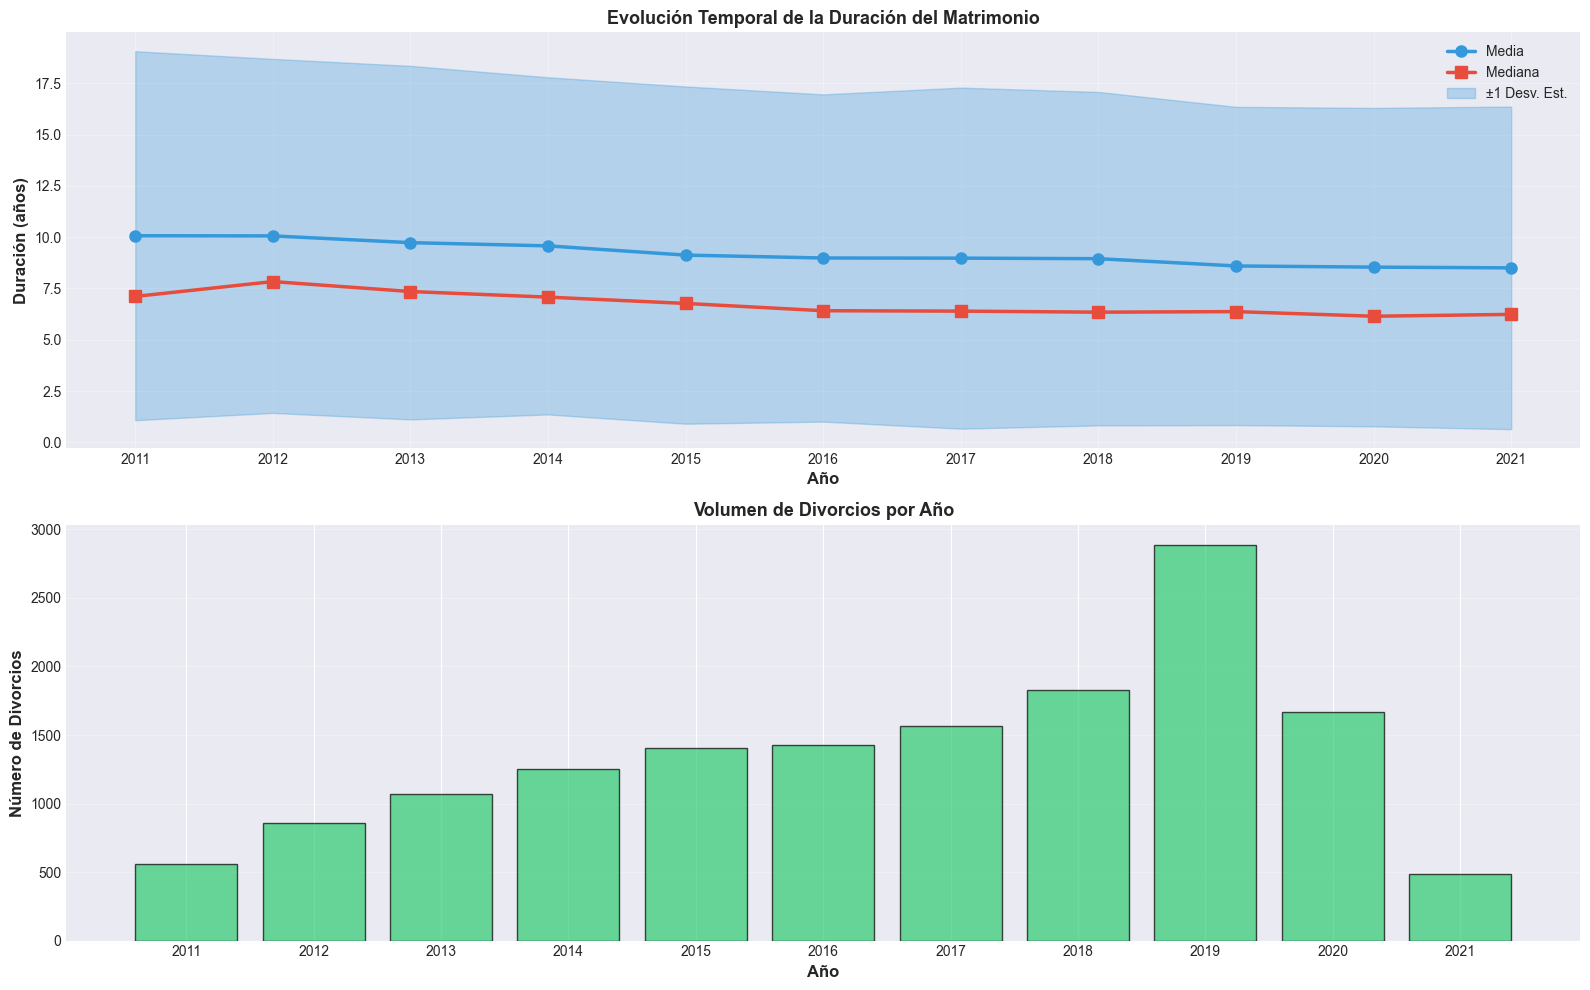

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# 8.1.1 Línea temporal
ax1 = axes[0]
ax1.plot(duracion_por_año['Año'], duracion_por_año['Media'], 
         marker='o', linewidth=2.5, markersize=8, color='#3498DB', label='Media')
ax1.plot(duracion_por_año['Año'], duracion_por_año['Mediana'], 
         marker='s', linewidth=2.5, markersize=8, color='#E74C3C', label='Mediana')
ax1.fill_between(duracion_por_año['Año'], 
                 duracion_por_año['Media'] - duracion_por_año['Std'],
                 duracion_por_año['Media'] + duracion_por_año['Std'],
                 alpha=0.3, color='#3498DB', label='±1 Desv. Est.')
ax1.set_xlabel('Año', fontsize=12, fontweight='bold')
ax1.set_ylabel('Duración (años)', fontsize=12, fontweight='bold')
ax1.set_title('Evolución Temporal de la Duración del Matrimonio', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(duracion_por_año['Año'])

# 8.1.2 Barras de casos por año
ax2 = axes[1]
bars = ax2.bar(duracion_por_año['Año'], duracion_por_año['N'], 
              color='#2ECC71', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Año', fontsize=12, fontweight='bold')
ax2.set_ylabel('Número de Divorcios', fontsize=12, fontweight='bold')
ax2.set_title('Volumen de Divorcios por Año', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticks(duracion_por_año['Año'])

plt.tight_layout()
plt.show()

## 9. Clustering: Patrones de Estabilidad Matrimonial

Agrupamos departamentos según patrones de duración.

### 9.1 Preparación para Clustering

In [15]:
# Preparar features
features_clustering = duracion_por_depto[['Media', 'Mediana', 'Std']].values

# Normalizar
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_clustering)

print("Datos preparados para clustering:")
print(f"   - {len(features_scaled)} departamentos")
print(f"   - Features: Media, Mediana, Desv. Est.")

Datos preparados para clustering:
   - 22 departamentos
   - Features: Media, Mediana, Desv. Est.


### 9.2 Determinación de K Óptimo

In [16]:
# Método del codo y silhouette
inertias = []
silhouette_scores = []
K_range = range(2, min(6, len(features_scaled)))

print("Evaluando diferentes números de clusters...")
print("="*80)
print(f"{'K':<5} {'Inercia':<15} {'Silhouette':<15} {'Interpretación'}")
print("="*80)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(features_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    
    if silhouette_avg > 0.5:
        interpretacion = "Buena"
    elif silhouette_avg > 0.3:
        interpretacion = "Aceptable"
    else:
        interpretacion = "Pobre"
    
    print(f"{k:<5} {kmeans.inertia_:<15.2f} {silhouette_avg:<15.4f} {interpretacion}")

# Determinar mejor K
best_k = K_range[np.argmax(silhouette_scores)]
best_silhouette = max(silhouette_scores)

print("\n" + "="*80)
print(f"✓ MEJOR NÚMERO DE CLUSTERS: K = {best_k}")
print(f"  Silhouette Score: {best_silhouette:.4f}")
print("="*80)

Evaluando diferentes números de clusters...
K     Inercia         Silhouette      Interpretación
2     24.91           0.5243          Buena
3     16.64           0.4603          Aceptable
4     12.51           0.3796          Aceptable
5     8.87            0.4178          Aceptable

✓ MEJOR NÚMERO DE CLUSTERS: K = 2
  Silhouette Score: 0.5243


### 9.3 Aplicar Clustering

In [17]:
# Aplicar clustering
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=20)
duracion_por_depto['Cluster'] = kmeans_final.fit_predict(features_scaled)

print(f"✓ Clustering aplicado")
print(f"\nDistribución por cluster:")
print(duracion_por_depto['Cluster'].value_counts().sort_index())

✓ Clustering aplicado

Distribución por cluster:
Cluster
0    13
1     9
Name: count, dtype: int64


### 9.4 Interpretación de Clusters

In [18]:
# Asignar nombres a clusters
cluster_chars = []
for cid in sorted(duracion_por_depto['Cluster'].unique()):
    cluster_data = duracion_por_depto[duracion_por_depto['Cluster'] == cid]
    cluster_chars.append({
        'cluster_id': cid,
        'duracion': cluster_data['Media'].mean()
    })

# Ordenar por duración
cluster_chars.sort(key=lambda x: x['duracion'], reverse=True)

# Nombres según K
cluster_names = {}
if best_k == 2:
    cluster_names[cluster_chars[0]['cluster_id']] = 'Alta Estabilidad'
    cluster_names[cluster_chars[1]['cluster_id']] = 'Baja Estabilidad'
elif best_k == 3:
    cluster_names[cluster_chars[0]['cluster_id']] = 'Alta Estabilidad'
    cluster_names[cluster_chars[1]['cluster_id']] = 'Estabilidad Media'
    cluster_names[cluster_chars[2]['cluster_id']] = 'Baja Estabilidad'
else:
    for i, char in enumerate(cluster_chars):
        cluster_names[char['cluster_id']] = f'Nivel {i+1}'

duracion_por_depto['Cluster_Nombre'] = duracion_por_depto['Cluster'].map(cluster_names)

print("\nCLUSTERS IDENTIFICADOS:")
for char in cluster_chars:
    cid = char['cluster_id']
    cluster_data = duracion_por_depto[duracion_por_depto['Cluster'] == cid]
    print(f"\n{cluster_names[cid]}")
    print(f"  Duración promedio: {char['duracion']:.2f} años")
    print(f"  Departamentos ({len(cluster_data)}): {', '.join(sorted(cluster_data['Departamento'].tolist()))}")


CLUSTERS IDENTIFICADOS:

Alta Estabilidad
  Duración promedio: 9.51 años
  Departamentos (13): Alta Verapaz, Baja Verapaz, Chimaltenango, Chiquimula, Escuintla, Huehuetenango, Jalapa, Jutiapa, Quetzaltenango, Sacatepéquez, San Marcos, Santa Rosa, Suchitepéquez

Baja Estabilidad
  Duración promedio: 8.43 años
  Departamentos (9): El Progreso, Guatemala, Izabal, Petén, Quiché, Retalhuleu, Sololá, Totonicapán, Zacapa


### 9.5 Visualización de Clusters

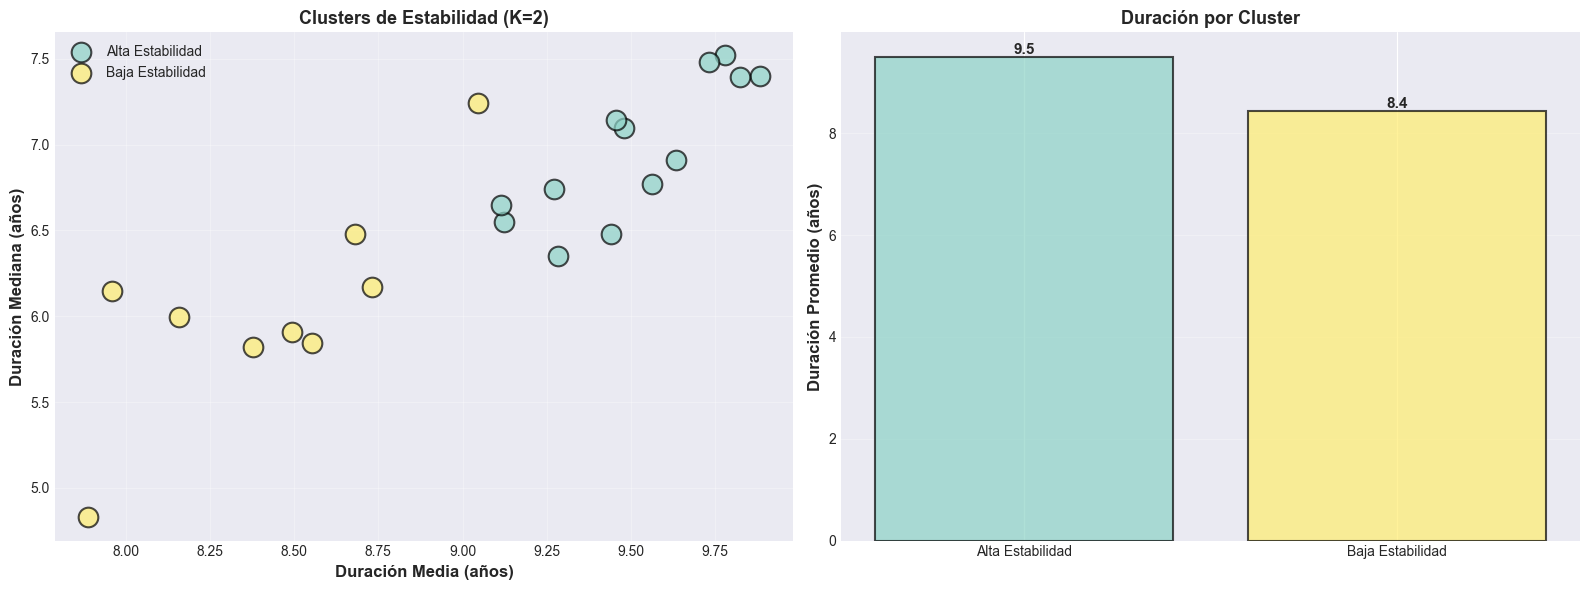

✓ Visualizaciones de clustering generadas


In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = plt.cm.Set3(np.linspace(0, 1, best_k))

# 9.5.1 Scatter Media vs Mediana
ax1 = axes[0]
for cluster_id in range(best_k):
    cluster_data = duracion_por_depto[duracion_por_depto['Cluster'] == cluster_id]
    ax1.scatter(cluster_data['Media'], cluster_data['Mediana'],
               s=200, alpha=0.7, color=colors[cluster_id], 
               edgecolors='black', linewidth=1.5,
               label=cluster_names[cluster_id])

ax1.set_xlabel('Duración Media (años)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Duración Mediana (años)', fontsize=12, fontweight='bold')
ax1.set_title(f'Clusters de Estabilidad (K={best_k})', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# 9.5.2 Barras por cluster
ax2 = axes[1]
cluster_means = [duracion_por_depto[duracion_por_depto['Cluster'] == i]['Media'].mean() 
                 for i in range(best_k)]
cluster_labels = [cluster_names[i] for i in range(best_k)]
bars = ax2.bar(cluster_labels, cluster_means, color=colors, 
              alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Duración Promedio (años)', fontsize=12, fontweight='bold')
ax2.set_title('Duración por Cluster', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Añadir valores
for bar, val in zip(bars, cluster_means):
    ax2.text(bar.get_x() + bar.get_width()/2, val, f'{val:.1f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Visualizaciones de clustering generadas")

## 10. Clasificación por Categorías de Duración

Categorizamos los matrimonios según su duración.

In [20]:
# Definir categorías
def clasificar_duracion(duracion):
    if duracion < 5:
        return 'Muy Corta (<5 años)'
    elif duracion < 10:
        return 'Corta (5-10 años)'
    elif duracion < 15:
        return 'Media (10-15 años)'
    elif duracion < 20:
        return 'Larga (15-20 años)'
    else:
        return 'Muy Larga (20+ años)'

divorcios_duracion['Categoria_Duracion'] = divorcios_duracion['Duracion_Promedio'].apply(clasificar_duracion)

# Contar por categoría
categoria_counts = divorcios_duracion['Categoria_Duracion'].value_counts()
categoria_pcts = (categoria_counts / len(divorcios_duracion) * 100).round(2)

print("DISTRIBUCIÓN POR CATEGORÍA DE DURACIÓN")
print(f"\n{'Categoría':<25} {'Cantidad':<12} {'Porcentaje'}")
print("-"*80)

# Ordenar por duración
orden_cat = ['Muy Corta (<5 años)', 'Corta (5-10 años)', 'Media (10-15 años)', 
             'Larga (15-20 años)', 'Muy Larga (20+ años)']

for cat in orden_cat:
    if cat in categoria_counts.index:
        print(f"{cat:<25} {categoria_counts[cat]:<12,} {categoria_pcts[cat]:.2f}%")

print("\nHALLAZGOS:")
cat_mas_comun = categoria_counts.idxmax()
pct_mas_comun = categoria_pcts[cat_mas_comun]
print(f"  • La categoría más común es: {cat_mas_comun} ({pct_mas_comun:.1f}%)")

pct_corta = categoria_pcts.get('Muy Corta (<5 años)', 0) + categoria_pcts.get('Corta (5-10 años)', 0)
print(f"  • {pct_corta:.1f}% de los matrimonios terminan en menos de 10 años")

pct_larga = categoria_pcts.get('Larga (15-20 años)', 0) + categoria_pcts.get('Muy Larga (20+ años)', 0)
print(f"  • {pct_larga:.1f}% de los matrimonios duran 15 años o más")

DISTRIBUCIÓN POR CATEGORÍA DE DURACIÓN

Categoría                 Cantidad     Porcentaje
--------------------------------------------------------------------------------
Muy Corta (<5 años)       6,046        40.27%
Corta (5-10 años)         3,807        25.36%
Media (10-15 años)        2,178        14.51%
Larga (15-20 años)        1,323        8.81%
Muy Larga (20+ años)      1,660        11.06%

HALLAZGOS:
  • La categoría más común es: Muy Corta (<5 años) (40.3%)
  • 65.6% de los matrimonios terminan en menos de 10 años
  • 19.9% de los matrimonios duran 15 años o más


### 10.1 Visualización de Categorías

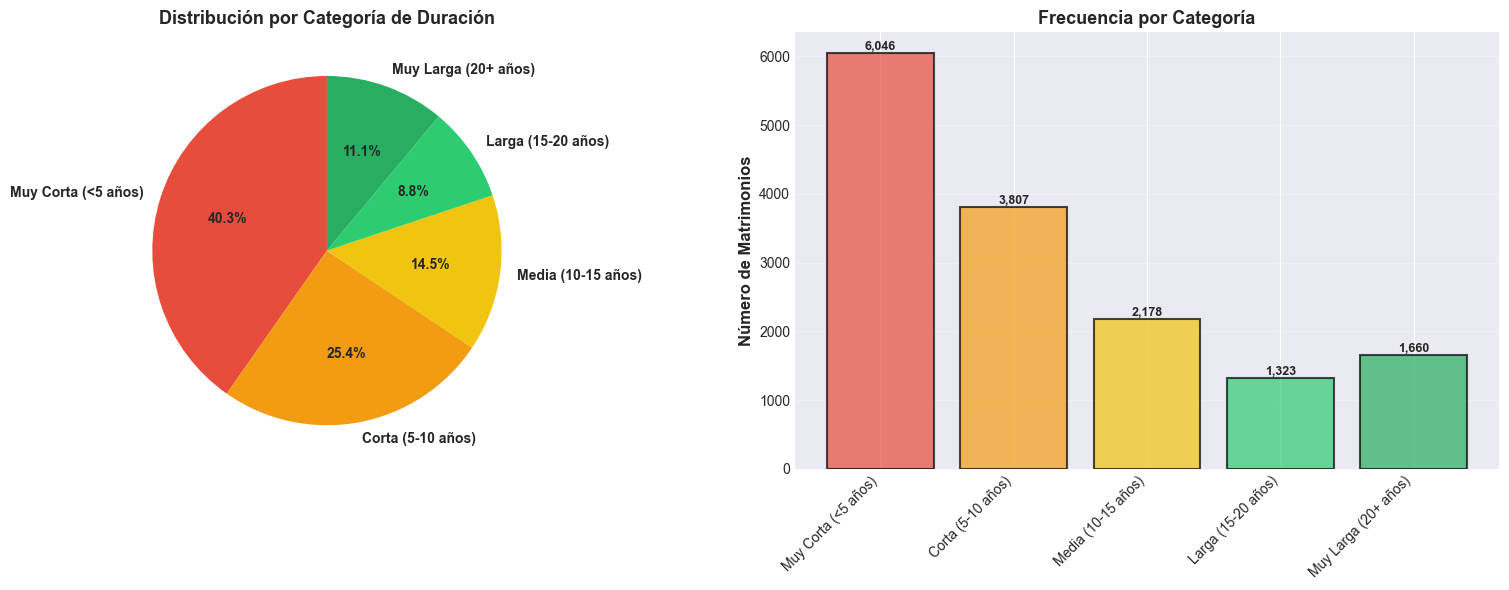

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Colores para categorías
colors_cat = ['#E74C3C', '#F39C12', '#F1C40F', '#2ECC71', '#27AE60']

# 10.1.1 Pie chart
ax1 = axes[0]
valores = [categoria_counts.get(cat, 0) for cat in orden_cat]
ax1.pie(valores, labels=orden_cat, autopct='%1.1f%%', colors=colors_cat,
       startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
ax1.set_title('Distribución por Categoría de Duración', fontsize=13, fontweight='bold')

# 10.1.2 Barras
ax2 = axes[1]
bars = ax2.bar(range(len(orden_cat)), valores, color=colors_cat, 
              alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_xticks(range(len(orden_cat)))
ax2.set_xticklabels(orden_cat, rotation=45, ha='right')
ax2.set_ylabel('Número de Matrimonios', fontsize=12, fontweight='bold')
ax2.set_title('Frecuencia por Categoría', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Añadir valores
for bar, val in zip(bars, valores):
    ax2.text(bar.get_x() + bar.get_width()/2, val, f'{val:,}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## 11. Resumen Final y Conclusiones

### 🔑 Hallazgos Principales:

1. **Duración Promedio**: Se calculó la duración típica del matrimonio antes del divorcio
2. **Diferencias por Género**: Se evaluaron posibles diferencias en experiencia de duración
3. **Patrones Geográficos**: Se identificaron departamentos con mayor/menor estabilidad
4. **Tendencias Temporales**: Se analizó la evolución en la última década
5. **Clusters de Estabilidad**: Se agruparon departamentos por patrones similares

---

### 💡 Implicaciones para Políticas Públicas:

1. **Intervención temprana**: Alta proporción de divorcios tempranos sugiere:
   - Programas de preparación prematrimonial
   - Servicios de mediación familiar accesibles
   - Terapia de pareja subsidiada

2. **Apoyo focalizado**: Identificar departamentos con menor estabilidad para:
   - Invertir en servicios de apoyo familiar
   - Programas educativos sobre relaciones saludables

3. **Tendencias temporales**: Monitorear cambios para:
   - Ajustar políticas sociales
   - Planificar servicios de transición

---

**Fin del Análisis de Duración de Matrimonios**